## Degron analysis

In this notebook, we examine cases where UPS substrates might be affected by mutations in cancer, either by impacting known degron sites, ubiquitination sites, or phosphodegrons.

In [1]:
# import needed packages
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
from matplotlib_venn import venn2, venn2_circles
mpl.rcParams['pdf.fonttype'] = 42
import utils

Read in all of the results.

In [5]:
# read in data
ub_df = utils.read_all_results_ub_sites()
phospho_df = utils.read_all_results_phosphodegron_sites()
degron_df = utils.read_all_results_known_degron()

# get the relevant cancer types
ub_ctypes = ub_df.groupby('gene')['cancer type'].unique()
phospho_ctypes = phospho_df.groupby('gene')['cancer type'].unique()
degron_ctypes = degron_df.groupby('gene')['cancer type'].unique()

### Heatmap

The next step is to merge all of the results together.

In [8]:
# unique the results
genes = ['CTNNB1', 'NFE2L2', 'CCND1', 'SF3B1', 'EPAS1', 'KIT', 'SPRY1']
ctype_dict = {g: set([]) for g in genes}
results = [ub_ctypes, phospho_ctypes, degron_ctypes]
for result in results:
    for g in result.index:
        if g in genes:
            ctype_dict[g] |= set(result.loc[g])

# create dataframe to plot a heatmap
all_cancer_types = [
    'ACC', 'BLCA', 'BRCA', 'CESC',
    'CHOL', 'COAD', 'DLBC', 'ESCA', 'GBM',
    'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML',
    'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO',
    'OV', 'PAAD', 'PCPG', 'PRAD', 'READ',
    'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA',
    'THYM', 'UCEC', 'UCS', 'UVM'
]
plot_df = pd.DataFrame({c: np.zeros(7) for c in all_cancer_types}, index=genes)
for g in genes:
    plot_df.loc[g, plot_df.columns.isin(ctype_dict[g])] = 1

Next, we plot a heatmap showing which cancer types a gene has significant enrichment for a known degron site, phosphodegron, or ubiquitination site.

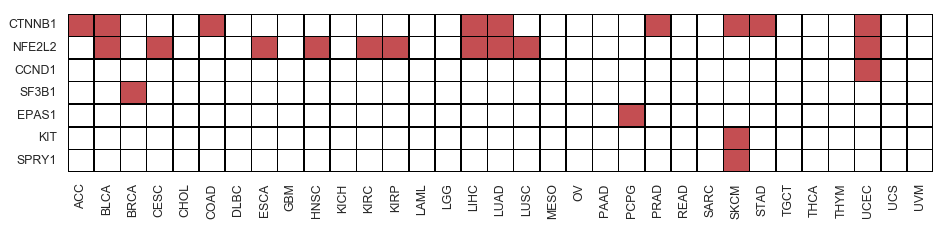

In [10]:
with sns.plotting_context('notebook'), sns.axes_style('whitegrid'):
    sns.heatmap(plot_df, mask=plot_df==0, cmap=['white', sns.color_palette()[3]], 
                linewidth=0.5, linecolor='black', cbar=False)
    plt.yticks(rotation=0)
    plt.gcf().set_size_inches(12, 3)
    plt.tight_layout()
    plt.savefig('figures/ups_substrate_sites.pdf')

### CCND1

In the next part of this notebook, we look into the evidence about CCND1 identified above.

In [12]:
# read in data
expr_df = pd.read_csv('data/degron/CCND1/UCEC.txt', sep='\t', usecols=['ID', 'CCND1', 'MKI67'])
mut_df = pd.read_csv('data/degron/CCND1/UCEC_mutations.txt', sep='\t')
mut_df['ID'] = mut_df['Tumor_Sample_Barcode'].str[:12]
subtype_df = pd.read_csv('data/degron/CCND1/tcga_cancer_subtypes.txt', sep='\t')
subtype_df = subtype_df.rename(columns={'PATIENT_BARCODE': 'ID', 'SUBTYPE': 'subtype'})
rppa_df = pd.read_csv('data/degron/CCND1/TCGA-RPPA-pancan-clean.txt', sep='\t', usecols=['SampleID', 'TumorType', 'CYCLIND1'])
rppa_df = rppa_df[rppa_df['TumorType']=='UCEC']
rppa_df['ID'] = rppa_df['SampleID'].str[:12]

Mark each tumor based on mutation status of CCND1.

In [13]:
# mark which samples contain CCND1 mutations
mut_df['mutation'] = 0

# mark non-silent mutations
nonsil = ['Missense_Mutation', 'Frame_Shift_Del', 'Nonsense_Mutation', 'Frame_Shift_Ins', 'Splice_Site',
          'In_Frame_Del', 'In_Frame_Ins', 'Nonstop_Mutation', 'Translation_Start_Site']
is_nonsil = mut_df['Variant_Classification'].isin(nonsil)
is_ccnd1 = mut_df['Hugo_Symbol']=='CCND1'
#mut_samps = mut_df[is_nonsil & is_ccnd1]['Tumor_Sample_Barcode'].str[:12].unique()
mut_df.loc[is_nonsil & is_ccnd1, 'mutation'] = 1

# mark which samples are in the phosphodegron region
phospho_pos = [str(x) for x in range(283, 292)]
is_phospho = mut_df['Protein_position'].isin(phospho_pos)
is_missense = mut_df['Variant_Classification']=='Missense_Mutation'
mut_df.loc[is_phospho & is_ccnd1 & is_missense, 'mutation'] = 2

# aggregate by sample
ccnd1_status = mut_df.groupby('ID')['mutation'].max().reset_index()
ccnd1_status['mutation'] = ccnd1_status['mutation'].replace({
    0: 'WT',
    1: 'non-silent (other)',
    2: 'missense (phosphodegron)'
})

Next, merge the mutation, tumor subtype, and RPPA protein expression data.

In [14]:
expr_df = pd.merge(expr_df, ccnd1_status, on='ID')
expr_df = pd.merge(expr_df, subtype_df[['ID', 'subtype']], on='ID')
expr_df = pd.merge(expr_df, rppa_df[['ID', "CYCLIND1"]], on='ID', how='left')

Plot the protein expression of Cyclin D1.

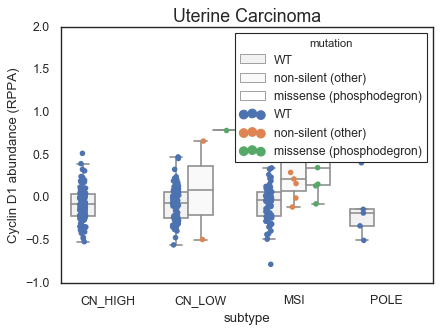

In [17]:
plot_order = ['WT', 
              'non-silent (other)', 
              'missense (phosphodegron)']
with sns.axes_style('white'):
    sns.boxplot(x='subtype', y='CYCLIND1', hue='mutation', 
                data=expr_df, hue_order=plot_order, color='white', 
                fliersize=0)
    sns.stripplot(x='subtype', y='CYCLIND1', hue='mutation', 
                  data=expr_df, hue_order=plot_order, dodge=True)
    plt.ylabel('Cyclin D1 abundance (RPPA)')
    plt.gcf().set_size_inches(6,4)
    plt.title('Uterine Carcinoma', size=16)
    plt.savefig('figures/ccnd1_prot_abundance.pdf')

Plot a marker of cell cycle progression, MKI67.

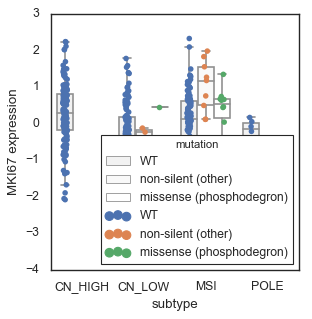

In [18]:
plot_order = ['WT', 'non-silent (other)', 'missense (phosphodegron)']
with sns.axes_style('white'):
    sns.boxplot(x='subtype', y='MKI67', hue='mutation', 
                data=expr_df, hue_order=plot_order, color='white', 
                fliersize=0)
    sns.stripplot(x='subtype', y='MKI67', hue='mutation', 
                  data=expr_df, hue_order=plot_order, dodge=True)
    plt.ylabel('MKI67 expression')
    plt.gcf().set_size_inches((4,4))
    plt.savefig('figures/MKI67_expression.pdf')

Create a heatmap of the t-statistics for the significance of the association of mutations in CCND1 with the MKI67 cell cycle marker.

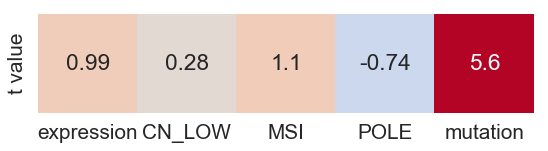

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

tmp_df = expr_df.copy()
tmp_df['mut'] = 1
tmp_df.loc[tmp_df['mutation']=='WT', 'mut'] = 0

result = smf.ols('CYCLIND1 ~ mut + subtype + CCND1', data=tmp_df).fit()
t_val = result.params / result.bse
#print(result.summary())

t_val = t_val.reset_index().rename(columns={0: 't value'})
t_val['index'] = t_val['index'].replace({
    'subtype[T.CN_LOW]': 'CN_LOW',
    'subtype[T.MSI]': 'MSI',
    'subtype[T.POLE]': 'POLE',
    'mut': 'mutation',
    'CCND1': 'expression'
})
t_val = t_val.set_index('index')

with sns.plotting_context('notebook', font_scale=1.7):
    myorder = ['expression', 'CN_LOW', 'MSI', 'POLE', 'mutation']
    sns.heatmap(t_val.T[myorder], cmap='coolwarm', 
                center=0, square=True, annot=True,
                cbar=False,
                cbar_kws={'orientation': 'horizontal'})
    plt.xlabel('')
    plt.savefig('figures/cyclind1_t_vals.pdf')

In [20]:
result.pvalues

Intercept            2.981271e-03
subtype[T.CN_LOW]    7.787675e-01
subtype[T.MSI]       2.859316e-01
subtype[T.POLE]      4.584859e-01
mut                  4.265189e-08
CCND1                3.242040e-01
dtype: float64

### CTNNB1

Here, we will analyze degron mutations in CTNNB1 and their relationship to immune-related biomarkers. We analyzed the relationship with 5 immune-related biomarkers: Leukocyte Fraction, TGFB response, IFNG response, MacrophageRegulation, and WoundHealing (Obtained from the "Immune Landscapes of Cancer" paper).

The first step is to analyze all the degron-related mutated genes:

In [26]:
# thresholds
qval_thresh = 0.1
count_thresh = 5

# read in the number of mutations per site
mut_ct_df = utils.read_mutation_flags('data/degron/mutation_flags_degron/')

# read in immune association
immune_df = pd.read_table('data/degron/immune_correlation_mutation_degron.txt')
split = immune_df.analysis.str.split('_', expand=True).rename(columns={0: 'cancer type', 1: 'gene'})
immune_df = pd.concat([immune_df, split], axis=1)
immune_df = pd.merge(immune_df, mut_ct_df, on=['gene', 'cancer type'], how='left')

# threshold base on num of mutations
lf_df = immune_df[(immune_df['variable']=='LeukocyteFraction') & (immune_df['count']>count_thresh)].copy()
lf_df['qvalue'] = utils.bh_fdr(lf_df['pvalue'])
tgfb_df = immune_df[(immune_df['variable']=='TGFB') & (immune_df['count']>count_thresh)].copy()
tgfb_df['qvalue'] = utils.bh_fdr(tgfb_df['pvalue'])
ifng_df = immune_df[(immune_df['variable']=='IFNG') & (immune_df['count']>count_thresh)].copy()
ifng_df['qvalue'] = utils.bh_fdr(ifng_df['pvalue'])
macrophage_df = immune_df[(immune_df['variable']=='MacrophageRegulation') & (immune_df['count']>count_thresh)].copy()
macrophage_df['qvalue'] = utils.bh_fdr(macrophage_df['pvalue'])
wound_df = immune_df[(immune_df['variable']=='WoundHealing') & (immune_df['count']>count_thresh)].copy()
wound_df['qvalue'] = utils.bh_fdr(wound_df['pvalue'])
lymph_df = immune_df[(immune_df['variable']=='LymphocyteInfiltration') & (immune_df['count']>count_thresh)].copy()
lymph_df['qvalue'] = utils.bh_fdr(lymph_df['pvalue'])
leuk_df = immune_df[(immune_df['variable']=='LeukocyteFraction') & (immune_df['count']>count_thresh)].copy()
leuk_df['qvalue'] = utils.bh_fdr(leuk_df['pvalue'])

# threshold based on significance
signif_immune = pd.concat([
     lymph_df[lymph_df['qvalue']<qval_thresh],
     leuk_df[leuk_df['qvalue']<qval_thresh],
     tgfb_df[tgfb_df['qvalue']<qval_thresh],
     ifng_df[ifng_df['qvalue']<qval_thresh],
     macrophage_df[macrophage_df['qvalue']<qval_thresh],
     wound_df[wound_df['qvalue']<qval_thresh]
])
uniq_signif = signif_immune['analysis'].unique()

Next, we plot a heatmap showing the significant results.

Text(61.0552,0.5,'')

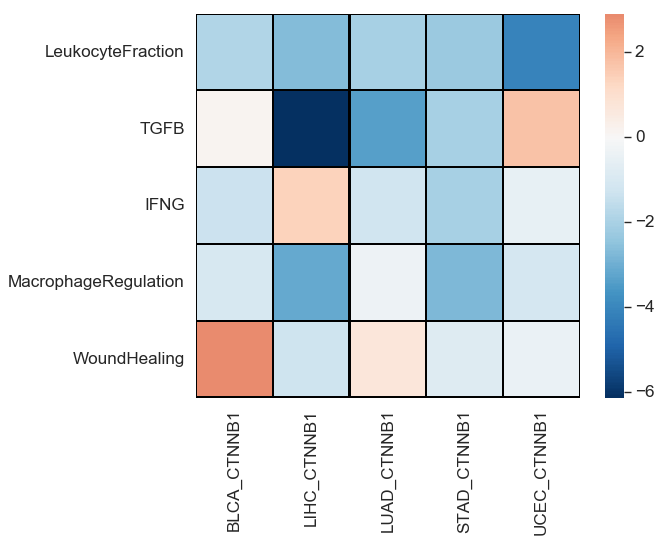

In [28]:
# which variables to plot on the heatmap
variable_list = [#'LymphocyteInfiltration', 
                 'LeukocyteFraction',
                 'TGFB', 'IFNG', 'MacrophageRegulation', 'WoundHealing']

# plot heatmap
is_variable = immune_df['variable'].isin(variable_list)
is_signif = immune_df['analysis'].isin(uniq_signif)
plot_df = immune_df[is_variable & is_signif].pivot(index='variable', columns='analysis', values='tvalue')

# plot heatmap
#fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)


with sns.plotting_context('notebook', font_scale=1.4):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    g = sns.heatmap(plot_df.loc[variable_list], square=True, cmap='RdBu_r', 
                    center=0, linewidth=1, linecolor='black',
                    cbar=True, 
                    #cbar_kws={"orientation": "horizontal", 
                              #'use_gridspec':False, 
                              #'location':"top"
                    #         }
                   )

plt.xlabel('')
plt.ylabel('')

Next, we look at what are the modulated transcription factors between CTNNB1 mutant and wildtype tumors.

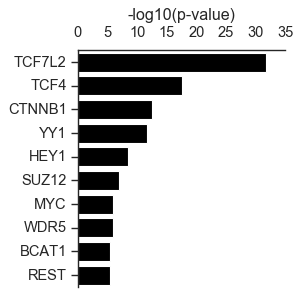

In [29]:
# read in rabit results
rabit = pd.read_csv('data/degron/CTNNB1_RABIT_PANCAN.txt', sep='\t')
rabit = rabit[~rabit['>CTNNB1'].isin(['Degree', 'CpG', 'Intercept'])]  # filter out covariates
rabit['transcription factor'] = rabit['>CTNNB1'].str.extract('\.(.+)@')  # gene symbol of TF
rabit = rabit.rename(columns={'Pr(>|t|)': 'p-value'})
rabit['-log10(p-value)'] = -np.log10(rabit['p-value'])
top10 = rabit[rabit['Estimate']>0].sort_values('p-value').head(10)

# plot results
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.2):
    ax = sns.barplot(top10['-log10(p-value)'], top10['transcription factor'], color='black')
    ax.tick_params(top=True, bottom=False)
    ax.xaxis.set_ticks_position('top')
    sns.despine(top=False, bottom=True, right=True)
    plt.xlabel('-log10(p-value)')
    ax.xaxis.set_label_position('top')
    plt.ylabel('')
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()
    plt.savefig('figures/ctnnb1_rabit_pancan.pdf')

### Save supplementary tables

Save the list of significantly mutated degrons, phosphodegrons, and ubiquitin sites. 

In [23]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('tables/TableS5.xlsx', engine='xlsxwriter')

# reformat column name
degron_df = degron_df.rename(columns={'num_degron_muts': 'number of mutations'})
phospho_df = phospho_df.rename(columns={'num_ub_site_muts': 'number of mutations'})
ub_df = ub_df.rename(columns={'num_ub_site_muts': 'number of mutations'})

# save sheets
col_order = ['gene', 'cancer type', 'number of mutations', 'pvalue', 'qvalue']
degron_df[col_order].to_excel(writer, sheet_name='degron', float_format='%.2G', index=False)
phospho_df[col_order].to_excel(writer, sheet_name='phosphodegron', float_format='%.2G', index=False)
ub_df[col_order].to_excel(writer, sheet_name='ub site', float_format='%.2G', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

Write the correlation of degron-related mutations and immune-related biomarkers.

In [35]:
all_immune = pd.concat([
     leuk_df,
     tgfb_df,
     ifng_df,
     macrophage_df,
     wound_df
])

col_order = ['gene', 'cancer type', 'variable', 'count', 'pvalue', 'qvalue']
all_immune[col_order].sort_values('pvalue').to_excel('tables/TableS6.xlsx', sheet_name='degron immune corr', 
                                                     float_format='%.2G', index=False)